# Deep learning for computer vision


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Main task
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [1]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

f:\vfomin\myexamples\dl\venv\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(40000L, 3L, 32L, 32L) (40000L,)


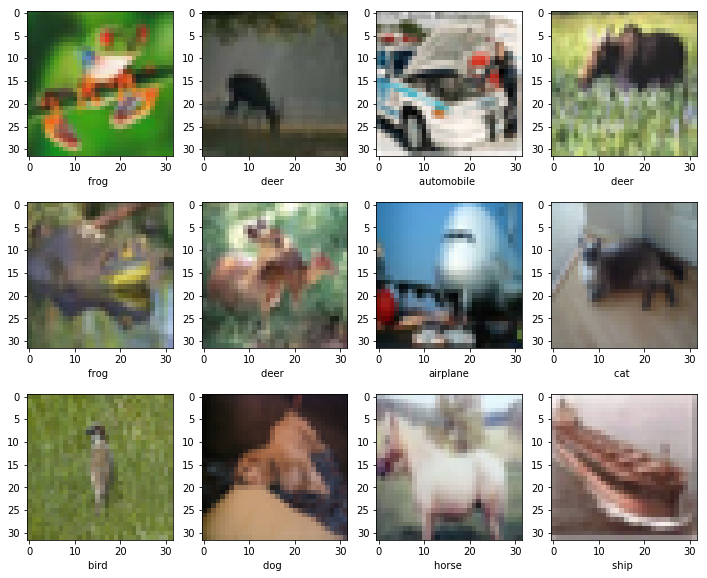

In [2]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano


In [3]:
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary")
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


Defining network architecture

In [4]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=100,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [5]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [6]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [7]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy (WITH dropout)
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [8]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)


In [9]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output,deterministic=True)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [10]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# X - a tensor of images with shape (many, 3, 32, 32), e.g. X_train
# y - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

#What do need to implement
# 1) Shuffle data
# - Gotta shuffle X and y the same way not to break the correspondence between X_i and y_i
# 3) Split data into minibatches of batch_size
# - If data size is not a multiple of batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(X, y, batchsize):
    
    n = X.shape[0]
    n_batches = n // batchsize
    
    random_indices = np.arange(n)
    np.random.shuffle(random_indices)
    for i in range(n_batches):
        end = min(i+batchsize, n)
        batch_indices = random_indices[i:end]
        X_batch = X[batch_indices, :, :, :]
        y_batch = y[batch_indices]
        yield (X_batch, y_batch)

#
#
# You feel lost and wish you stayed home tonight?
# Go search for a similar function at
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

# Training loop

In [11]:
import time

num_epochs = 100 #amount of passes through the data
            
batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 1.007s
  training loss (in-iteration):		2.017551
  train accuracy:		30.48 %
  validation accuracy:		19.88 %
Epoch 2 of 100 took 0.872s
  training loss (in-iteration):		1.885637
  train accuracy:		36.92 %
  validation accuracy:		21.70 %
Epoch 3 of 100 took 0.894s
  training loss (in-iteration):		1.781359
  train accuracy:		37.66 %
  validation accuracy:		29.45 %
Epoch 4 of 100 took 0.972s
  training loss (in-iteration):		1.761620
  train accuracy:		38.98 %
  validation accuracy:		34.70 %
Epoch 5 of 100 took 0.937s
  training loss (in-iteration):		1.671206
  train accuracy:		43.96 %
  validation accuracy:		27.95 %
Epoch 6 of 100 took 0.909s
  training loss (in-iteration):		1.719322
  train accuracy:		41.90 %
  validation accuracy:		29.60 %
Epoch 7 of 100 took 0.882s
  training loss (in-iteration):		1.675732
  train accuracy:		42.60 %
  validation accuracy:		31.36 %
Epoch 8 of 100 took 0.963s
  training loss (in-iteration):		1.645246
  train accuracy:		43.77 %
  valida

In [12]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		34.81 %
We need more magic!


# First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

Train it with Adam optimizer with default params.


# Second step

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


# Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)
    
## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [13]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

(40000L, 3L, 32L, 32L) (40000L,)


In [14]:
import lasagne

input_X = T.tensor4("Input X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

In [16]:
lasagne.layers.Pool2DLayer??

In [ ]:
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer

#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape=input_shape,input_var=input_X)

# Network architecture : X -> Conv3x3 -> ReLU -> Conv3x3 -> ReLU -> Pool -> Dropout => Conv3x3 -> Conv3x3 -> Pool -> Dropout -> FC -> FC -> Y

conv_1_3x3 = Conv2DLayer(input_layer, num_filters=10, filter_size=3, 
                                        nonlinearity=lasagne.nonlinearities.softmax,
                                        name="Conv_1_3x3")

conv_2_3x3 = Conv2DLayer(conv_1_3x3, num_filters=10, filter_size=3, 
                                    nonlinearity=lasagne.nonlinearities.softmax, 
                                    name="Conv_2_3x3")

# pool_3 = Pool2DLayer(conv_2_3x3, )

# <student.code_neural_network_architecture()>

dense_output = <your network output>

In [ ]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [ ]:
#All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

In [ ]:
#loss function
loss = <loss function>

#<optionally add regularization>

#accuracy with dropout/noize
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#weight updates
updates = <try different update methods>

In [ ]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)


In [ ]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

In [ ]:
#итерации обучения

num_epochs = <how many times to iterate over the entire training set>

batch_size = <how many samples are processed at a single function call>

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"

Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]